In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
import optuna
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]


In [4]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


label
clap             118
hihat_closed     187
hihat_open       280
kick             648
rim              105
snare            731
synth_noise     6000
tom_high         179
tom_low          188
tom_mid          139
Name: path, dtype: int64


In [5]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
ds[0]

{'signal': tensor([-0.0003, -0.0019,  0.0305,  ...,  0.0000,  0.0000,  0.0000]),
 'label': tensor(0),
 'path': './dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav',
 'drum_type': 'tom_high'}

torch.Size([1, 30, 20]) tensor([3.7780e-07, 4.3663e-07, 5.1748e-07, 7.8316e-07, 1.0940e-06, 1.2390e-06,
        1.0736e-06, 1.3535e-06, 2.2968e-06, 3.7080e-06, 6.0161e-06, 1.3278e-05,
        4.6197e-04, 8.3736e-04, 5.2762e-06, 2.5157e-06, 3.3073e-06, 7.1799e-05,
        2.6288e-04, 7.9382e-06, 9.9993e-06, 1.3596e-04, 1.9603e-05, 5.6001e-05,
        4.2964e-05, 1.4321e-05, 2.6561e-06, 1.5324e-07, 1.0450e-07, 8.6483e-08])
('tom_low', 1) tensor(1) 44100


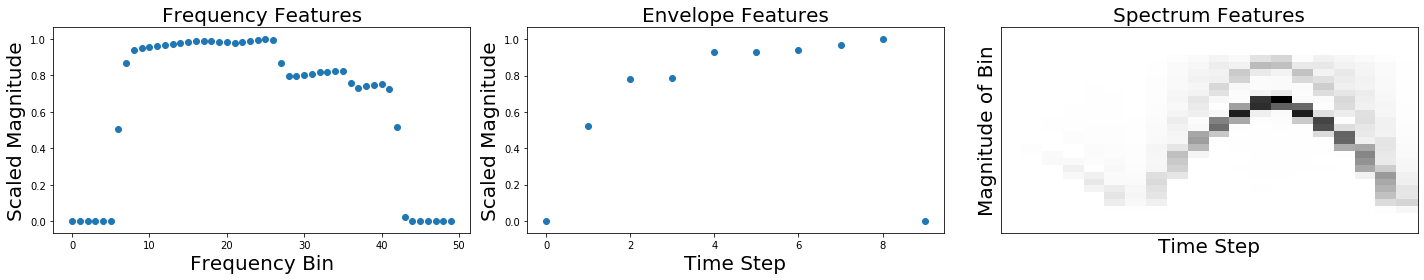

In [6]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,ft[0,:,0])
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER

In [38]:
class AE_Linear_1H(nn.Module):
    def __init__(self,compression_dim=64,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.dropout(torch.relu(activation))
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Linear_2H(nn.Module):
    def __init__(self,compression_dim=8,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer1 = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_hidden_layer2 = nn.Linear(
            in_features=128, out_features=32
        )
        self.encoder_output_layer = nn.Linear(
            in_features=32, out_features=compression_dim
        )
        self.decoder_hidden_layer1 = nn.Linear(
            in_features=compression_dim, out_features=32
        )
        self.decoder_hidden_layer2 = nn.Linear(
            in_features=32, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer1(features)
        activation = self.dropout(torch.relu(activation))
        h1_out = self.encoder_hidden_layer2(activation)
        h1_out = self.dropout(torch.relu(h1_out))
        code = self.encoder_output_layer(h1_out)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer1(code)
        activation = self.decoder_hidden_layer2(activation)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Conv(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate,num_channels=5):
        super(AE_Conv, self).__init__()
        self.W=input_shape[0]
        self.H=input_shape[1]

        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=num_channels, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.encoder_output_layer = nn.Linear(
            in_features=(self.H//2 * self.W//2) * 8, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [39]:
compression_dim=8
spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)
train_synthless=train[train["label_num"]==0]
spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=pt)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)

In [42]:
def objective(trial):

    #hyper params
    learning_rate = trial.suggest_uniform('Learning Rate', 1e-4,1e-1)
    dropout_rate = trial.suggest_discrete_uniform('Dropout Rate', 0,0.5,0.1)
    latent_size = trial.suggest_categorical('Latent Size',[4, 16, 64])
    optimizer_type = trial.suggest_categorical('Optimizer', ['Adam', 'SGD'])
    FREQ_BINS = trial.suggest_categorical('Frequency Bins', [10, 30, 60])
    TIME_STEPS = trial.suggest_categorical('Time Steps', [10, 20])
    hidden_layers= trial.suggest_int('Hidden Layers', 1, 2)
    l2=trial.suggest_loguniform('L2 Regularization', 1e-6,1e-1)
    model_type=trial.suggest_categorical('Model Type', ['CNN', 'FC'])
    num_channels=5

    spec_dimension=FREQ_BINS*TIME_STEPS

    criterion=nn.MSELoss()
    
    #make model
    if hidden_layers==1:
        model = AE_Linear_1H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    else:
        model = AE_Linear_2H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    if model_type=="CNN":
        model = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=num_channels).to(device)
        
    if optimizer_type=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
    elif optimizer_type=="SGD":
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=l2)
    #make dataloader 
    ptTune=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
    spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=ptTune)
    spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)
    
    #train
    epochs=15
    for epoch in range(epochs):
        loss = 0
        for batch_features in spec_train_nosynth_loader:
            batch_features=batch_features["feats"]
            batch_features = batch_features.view(-1, spec_dimension).to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(spec_train_nosynth_loader)
        trial.report(loss, epoch)   
        if epoch%2==0:
            if trial.should_prune():
                raise optuna.TrialPruned()
            print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs, loss))
    return loss
study = optuna.create_study(study_name='Study_ALL',sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner(), storage='sqlite:///optuna.db',load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2020-07-18 21:06:16,771] A new study created with name: Study_ALL


epoch : 0/15, loss = 0.007201
epoch : 2/15, loss = 0.005719
epoch : 4/15, loss = 0.005721
epoch : 6/15, loss = 0.005727
epoch : 8/15, loss = 0.005790
epoch : 10/15, loss = 0.005711
epoch : 12/15, loss = 0.005735
epoch : 14/15, loss = 0.005760


[I 2020-07-18 21:07:14,185] Finished trial#0 with value: 0.005760425172092123 with parameters: {'Learning Rate': 0.029768048295101848, 'Dropout Rate': 0.5, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.0025006613840012682, 'Model Type': 'CNN'}. Best is trial#0 with value: 0.005760425172092123.


epoch : 0/15, loss = 0.006535
epoch : 2/15, loss = 0.005002
epoch : 4/15, loss = 0.004744
epoch : 6/15, loss = 0.004452
epoch : 8/15, loss = 0.004541
epoch : 10/15, loss = 0.004374
epoch : 12/15, loss = 0.004549
epoch : 14/15, loss = 0.004387


[I 2020-07-18 21:08:06,669] Finished trial#1 with value: 0.004387061270700327 with parameters: {'Learning Rate': 0.010910259294355932, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 5.896132836325513e-05, 'Model Type': 'FC'}. Best is trial#1 with value: 0.004387061270700327.


epoch : 0/15, loss = 0.015037
epoch : 2/15, loss = 0.009513
epoch : 4/15, loss = 0.008136
epoch : 6/15, loss = 0.007565
epoch : 8/15, loss = 0.007298
epoch : 10/15, loss = 0.007104
epoch : 12/15, loss = 0.007048
epoch : 14/15, loss = 0.006925


[I 2020-07-18 21:09:31,486] Finished trial#2 with value: 0.0069251065071359395 with parameters: {'Learning Rate': 0.006946999370170731, 'Dropout Rate': 0.5, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.003057396370908644, 'Model Type': 'FC'}. Best is trial#1 with value: 0.004387061270700327.


epoch : 0/15, loss = 0.006669
epoch : 2/15, loss = 0.006399
epoch : 4/15, loss = 0.006419
epoch : 6/15, loss = 0.006401
epoch : 8/15, loss = 0.006364
epoch : 10/15, loss = 0.006399
epoch : 12/15, loss = 0.006412
epoch : 14/15, loss = 0.006396


[I 2020-07-18 21:10:56,371] Finished trial#3 with value: 0.00639618844156445 with parameters: {'Learning Rate': 0.04594047303488708, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00046293456935160674, 'Model Type': 'FC'}. Best is trial#1 with value: 0.004387061270700327.


epoch : 0/15, loss = 0.007128
epoch : 2/15, loss = 0.005177
epoch : 4/15, loss = 0.004747
epoch : 6/15, loss = 0.004509
epoch : 8/15, loss = 0.004387
epoch : 10/15, loss = 0.004296
epoch : 12/15, loss = 0.004245
epoch : 14/15, loss = 0.004215


[I 2020-07-18 21:12:24,469] Finished trial#4 with value: 0.0042147635116121015 with parameters: {'Learning Rate': 0.02830638928286765, 'Dropout Rate': 0.5, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.7423002992682354e-05, 'Model Type': 'FC'}. Best is trial#4 with value: 0.0042147635116121015.


epoch : 0/15, loss = 0.002873
epoch : 2/15, loss = 0.002516
epoch : 4/15, loss = 0.002542
epoch : 6/15, loss = 0.002526
epoch : 8/15, loss = 0.002536
epoch : 10/15, loss = 0.002526
epoch : 12/15, loss = 0.002564
epoch : 14/15, loss = 0.002517


[I 2020-07-18 21:13:57,769] Finished trial#5 with value: 0.0025169140390895366 with parameters: {'Learning Rate': 0.06499553694787287, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00017075914666414286, 'Model Type': 'CNN'}. Best is trial#5 with value: 0.0025169140390895366.


epoch : 0/15, loss = 0.007793
epoch : 2/15, loss = 0.004443
epoch : 4/15, loss = 0.004146
epoch : 6/15, loss = 0.004018
epoch : 8/15, loss = 0.003972
epoch : 10/15, loss = 0.003969
epoch : 12/15, loss = 0.003961
epoch : 14/15, loss = 0.003961


[I 2020-07-18 21:15:08,366] Finished trial#6 with value: 0.003960726206823615 with parameters: {'Learning Rate': 0.03509102465783208, 'Dropout Rate': 0.1, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.0018975195450550522, 'Model Type': 'FC'}. Best is trial#5 with value: 0.0025169140390895366.


epoch : 0/15, loss = 0.006572
epoch : 2/15, loss = 0.006412


[I 2020-07-18 21:15:36,645] Setting status of trial#7 as TrialState.PRUNED. 


epoch : 0/15, loss = 6.506114
epoch : 2/15, loss = 0.002987
epoch : 4/15, loss = 0.003138
epoch : 6/15, loss = 0.019637
epoch : 8/15, loss = 0.002978
epoch : 10/15, loss = 0.002962
epoch : 12/15, loss = 0.003587
epoch : 14/15, loss = 0.005159


[I 2020-07-18 21:17:09,778] Finished trial#8 with value: 0.005158935630878874 with parameters: {'Learning Rate': 0.08064151814339622, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.409497773636902e-05, 'Model Type': 'FC'}. Best is trial#5 with value: 0.0025169140390895366.


epoch : 0/15, loss = 0.006347
epoch : 2/15, loss = 0.004821


[I 2020-07-18 21:17:37,889] Setting status of trial#9 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005727
epoch : 2/15, loss = 0.005194


[I 2020-07-18 21:18:01,589] Setting status of trial#10 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.004787
epoch : 2/15, loss = 0.004702
epoch : 4/15, loss = 0.004674
epoch : 6/15, loss = 0.004685
epoch : 8/15, loss = 0.004687


[I 2020-07-18 21:19:05,748] Setting status of trial#11 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.006043
epoch : 2/15, loss = 0.003883
epoch : 4/15, loss = 0.003768
epoch : 6/15, loss = 0.003801
epoch : 8/15, loss = 0.003803


[I 2020-07-18 21:20:10,564] Setting status of trial#12 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.008010


[I 2020-07-18 21:20:27,867] Setting status of trial#13 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005528
epoch : 2/15, loss = 0.004636
epoch : 4/15, loss = 0.004602
epoch : 6/15, loss = 0.004560
epoch : 8/15, loss = 0.004544


[I 2020-07-18 21:21:20,298] Setting status of trial#14 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.008154
epoch : 2/15, loss = 0.008347


[I 2020-07-18 21:21:49,134] Setting status of trial#15 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003971
epoch : 2/15, loss = 0.003925
epoch : 4/15, loss = 0.003961
epoch : 6/15, loss = 0.003902
epoch : 8/15, loss = 0.003947


[I 2020-07-18 21:22:54,293] Setting status of trial#16 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.012389


[I 2020-07-18 21:23:05,047] Setting status of trial#17 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002643
epoch : 2/15, loss = 0.002587
epoch : 4/15, loss = 0.002596
epoch : 6/15, loss = 0.002610
epoch : 8/15, loss = 0.002594
epoch : 10/15, loss = 0.002593
epoch : 12/15, loss = 0.002600
epoch : 14/15, loss = 0.002596


[I 2020-07-18 21:24:37,797] Finished trial#18 with value: 0.002595746178777163 with parameters: {'Learning Rate': 0.07631482927659435, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0009847313238726106, 'Model Type': 'FC'}. Best is trial#5 with value: 0.0025169140390895366.


epoch : 0/15, loss = 0.008147


[I 2020-07-18 21:24:54,630] Setting status of trial#19 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003957
epoch : 2/15, loss = 0.003928
epoch : 4/15, loss = 0.003928
epoch : 6/15, loss = 0.003927
epoch : 8/15, loss = 0.003959
epoch : 10/15, loss = 0.003917
epoch : 12/15, loss = 0.003917
epoch : 14/15, loss = 0.003917


[I 2020-07-18 21:26:06,578] Finished trial#20 with value: 0.0039167492614902615 with parameters: {'Learning Rate': 0.046962650989548355, 'Dropout Rate': 0.5, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.0016944508012834033, 'Model Type': 'FC'}. Best is trial#5 with value: 0.0025169140390895366.


epoch : 0/15, loss = 0.007897
epoch : 2/15, loss = 0.005850


[I 2020-07-18 21:26:25,817] Setting status of trial#21 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002316
epoch : 2/15, loss = 0.001511
epoch : 4/15, loss = 0.001332
epoch : 6/15, loss = 0.001272
epoch : 8/15, loss = 0.001233
epoch : 10/15, loss = 0.001199
epoch : 12/15, loss = 0.001136
epoch : 14/15, loss = 0.001129


[I 2020-07-18 21:27:37,242] Finished trial#22 with value: 0.0011292714885531975 with parameters: {'Learning Rate': 0.00374997206650627, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 1.0131020374110523e-06, 'Model Type': 'FC'}. Best is trial#22 with value: 0.0011292714885531975.


epoch : 0/15, loss = 0.002568
epoch : 2/15, loss = 0.001884
epoch : 4/15, loss = 0.001823
epoch : 6/15, loss = 0.001825
epoch : 8/15, loss = 0.001788
epoch : 10/15, loss = 0.001785
epoch : 12/15, loss = 0.001774
epoch : 14/15, loss = 0.001752


[I 2020-07-18 21:28:48,183] Finished trial#23 with value: 0.0017523966798068287 with parameters: {'Learning Rate': 0.012091749164589036, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 1.2761377091859854e-06, 'Model Type': 'FC'}. Best is trial#22 with value: 0.0011292714885531975.


epoch : 0/15, loss = 0.021748
epoch : 2/15, loss = 0.007027


[I 2020-07-18 21:29:07,451] Setting status of trial#24 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005214
epoch : 2/15, loss = 0.004738
epoch : 4/15, loss = 0.004475
epoch : 6/15, loss = 0.004332
epoch : 8/15, loss = 0.004250


[I 2020-07-18 21:29:59,899] Setting status of trial#25 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003169
epoch : 2/15, loss = 0.001587
epoch : 4/15, loss = 0.001393
epoch : 6/15, loss = 0.001245
epoch : 8/15, loss = 0.001158
epoch : 10/15, loss = 0.001106
epoch : 12/15, loss = 0.001071
epoch : 14/15, loss = 0.001049


[I 2020-07-18 21:31:10,863] Finished trial#26 with value: 0.0010487575007101365 with parameters: {'Learning Rate': 0.001059759581690608, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 1.5921111100748799e-06, 'Model Type': 'FC'}. Best is trial#26 with value: 0.0010487575007101365.


epoch : 0/15, loss = 0.017737
epoch : 2/15, loss = 0.009851
epoch : 4/15, loss = 0.009202
epoch : 6/15, loss = 0.009181
epoch : 8/15, loss = 0.009204


[I 2020-07-18 21:32:12,681] Setting status of trial#27 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002828
epoch : 2/15, loss = 0.001493
epoch : 4/15, loss = 0.001288
epoch : 6/15, loss = 0.001193
epoch : 8/15, loss = 0.001130
epoch : 10/15, loss = 0.001091
epoch : 12/15, loss = 0.001054
epoch : 14/15, loss = 0.001027


[I 2020-07-18 21:33:23,297] Finished trial#28 with value: 0.0010268575079092144 with parameters: {'Learning Rate': 0.0012995497777308004, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 1.1271634713059379e-06, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.002573
epoch : 2/15, loss = 0.002146


[I 2020-07-18 21:33:46,891] Setting status of trial#29 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005081
epoch : 2/15, loss = 0.004415
epoch : 4/15, loss = 0.004212
epoch : 6/15, loss = 0.004145
epoch : 8/15, loss = 0.004120


[I 2020-07-18 21:34:38,740] Setting status of trial#30 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.004992
epoch : 2/15, loss = 0.004669
epoch : 4/15, loss = 0.004658
epoch : 6/15, loss = 0.004664
epoch : 8/15, loss = 0.004664


[I 2020-07-18 21:35:43,090] Setting status of trial#31 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002697
epoch : 2/15, loss = 0.002533
epoch : 4/15, loss = 0.002528
epoch : 6/15, loss = 0.002521
epoch : 8/15, loss = 0.002524


[I 2020-07-18 21:36:51,475] Setting status of trial#32 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.012578
epoch : 2/15, loss = 0.010672
epoch : 4/15, loss = 0.010611
epoch : 6/15, loss = 0.010650
epoch : 8/15, loss = 0.010698


[I 2020-07-18 21:37:29,760] Setting status of trial#33 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005110
epoch : 2/15, loss = 0.004239
epoch : 4/15, loss = 0.003795
epoch : 6/15, loss = 0.003801
epoch : 8/15, loss = 0.003818


[I 2020-07-18 21:38:21,392] Setting status of trial#34 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003153
epoch : 2/15, loss = 0.001592
epoch : 4/15, loss = 0.001371
epoch : 6/15, loss = 0.001257
epoch : 8/15, loss = 0.001177
epoch : 10/15, loss = 0.001115
epoch : 12/15, loss = 0.001073
epoch : 14/15, loss = 0.001038


[I 2020-07-18 21:39:31,913] Finished trial#35 with value: 0.0010382825071489766 with parameters: {'Learning Rate': 0.0008508606837713346, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 3.1453541914389663e-06, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.002903


[I 2020-07-18 21:39:46,080] Setting status of trial#36 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005065


[I 2020-07-18 21:39:57,949] Setting status of trial#37 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002830


[I 2020-07-18 21:40:12,092] Setting status of trial#38 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.004284


[I 2020-07-18 21:40:26,181] Setting status of trial#39 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.006863
epoch : 2/15, loss = 0.005903


[I 2020-07-18 21:40:45,343] Setting status of trial#40 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.004603


[I 2020-07-18 21:40:59,562] Setting status of trial#41 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003509
epoch : 2/15, loss = 0.002857
epoch : 4/15, loss = 0.002861
epoch : 6/15, loss = 0.002858
epoch : 8/15, loss = 0.002864


[I 2020-07-18 21:42:07,643] Setting status of trial#42 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005684
epoch : 2/15, loss = 0.005523


[I 2020-07-18 21:42:27,322] Setting status of trial#43 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003332
epoch : 2/15, loss = 0.001544
epoch : 4/15, loss = 0.001326
epoch : 6/15, loss = 0.001216
epoch : 8/15, loss = 0.001125
epoch : 10/15, loss = 0.001091
epoch : 12/15, loss = 0.001047
epoch : 14/15, loss = 0.001029


[I 2020-07-18 21:43:38,133] Finished trial#44 with value: 0.0010287659211645885 with parameters: {'Learning Rate': 0.0007947824136708289, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 1.1442384472710743e-06, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.005135
epoch : 2/15, loss = 0.004906
epoch : 4/15, loss = 0.005009
epoch : 6/15, loss = 0.004847
epoch : 8/15, loss = 0.005358


[I 2020-07-18 21:44:20,747] Setting status of trial#45 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003375
epoch : 2/15, loss = 0.002855
epoch : 4/15, loss = 0.002870
epoch : 6/15, loss = 0.002869
epoch : 8/15, loss = 0.002860


[I 2020-07-18 21:45:28,927] Setting status of trial#46 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002707
epoch : 2/15, loss = 0.001957


[I 2020-07-18 21:45:52,691] Setting status of trial#47 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.006210
epoch : 2/15, loss = 0.004142


[I 2020-07-18 21:46:22,046] Setting status of trial#48 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005884
epoch : 2/15, loss = 0.005220


[I 2020-07-18 21:46:45,671] Setting status of trial#49 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003809
epoch : 2/15, loss = 0.001703


[I 2020-07-18 21:47:09,048] Setting status of trial#50 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002700


[I 2020-07-18 21:47:23,365] Setting status of trial#51 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003825


[I 2020-07-18 21:47:37,809] Setting status of trial#52 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003406


[I 2020-07-18 21:47:49,439] Setting status of trial#53 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.006128
epoch : 2/15, loss = 0.005937
epoch : 4/15, loss = 0.005949
epoch : 6/15, loss = 0.005927
epoch : 8/15, loss = 0.005931


[I 2020-07-18 21:48:32,133] Setting status of trial#54 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005374
epoch : 2/15, loss = 0.004618


[I 2020-07-18 21:49:02,006] Setting status of trial#55 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002942
epoch : 2/15, loss = 0.002893
epoch : 4/15, loss = 0.002882
epoch : 6/15, loss = 0.002885
epoch : 8/15, loss = 0.002917
epoch : 10/15, loss = 0.002884
epoch : 12/15, loss = 0.002884
epoch : 14/15, loss = 0.002887


[I 2020-07-18 21:50:34,433] Finished trial#56 with value: 0.002887428667972163 with parameters: {'Learning Rate': 0.06281782218856267, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.019902887212752237, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.004145


[I 2020-07-18 21:50:48,549] Setting status of trial#57 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002303
epoch : 2/15, loss = 0.001589


[I 2020-07-18 21:51:12,193] Setting status of trial#58 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.008285


[I 2020-07-18 21:51:26,634] Setting status of trial#59 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002479
epoch : 2/15, loss = 0.001821


[I 2020-07-18 21:51:50,423] Setting status of trial#60 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002852
epoch : 2/15, loss = 0.001589
epoch : 4/15, loss = 0.001367
epoch : 6/15, loss = 0.001277
epoch : 8/15, loss = 0.001174
epoch : 10/15, loss = 0.001133
epoch : 12/15, loss = 0.001098
epoch : 14/15, loss = 0.001088


[I 2020-07-18 21:53:00,973] Finished trial#61 with value: 0.0010884667109993095 with parameters: {'Learning Rate': 0.001673372281537491, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 1.9651904571475013e-06, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.006332
epoch : 2/15, loss = 0.004065
epoch : 4/15, loss = 0.003980
epoch : 6/15, loss = 0.004013
epoch : 8/15, loss = 0.003976


[I 2020-07-18 21:53:52,612] Setting status of trial#62 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002637


[I 2020-07-18 21:54:06,754] Setting status of trial#63 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.004172
epoch : 2/15, loss = 0.001885


[I 2020-07-18 21:54:30,476] Setting status of trial#64 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002968
epoch : 2/15, loss = 0.002893
epoch : 4/15, loss = 0.002899
epoch : 6/15, loss = 0.002888
epoch : 8/15, loss = 0.002888
epoch : 10/15, loss = 0.002895
epoch : 12/15, loss = 0.002907
epoch : 14/15, loss = 0.002899


[I 2020-07-18 21:56:04,410] Finished trial#65 with value: 0.0028989398123284104 with parameters: {'Learning Rate': 0.06222618999694436, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.023461029413462613, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.037319
epoch : 2/15, loss = 0.003901
epoch : 4/15, loss = 0.003889
epoch : 6/15, loss = 0.003932
epoch : 8/15, loss = 0.003911


[I 2020-07-18 21:57:09,970] Setting status of trial#66 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.001759
epoch : 2/15, loss = 0.001212
epoch : 4/15, loss = 0.001130
epoch : 6/15, loss = 0.001086
epoch : 8/15, loss = 0.001075
epoch : 10/15, loss = 0.001064
epoch : 12/15, loss = 0.001052
epoch : 14/15, loss = 0.001048


[I 2020-07-18 21:58:42,335] Finished trial#67 with value: 0.0010484257208197626 with parameters: {'Learning Rate': 0.006040920567079177, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 2.487214734542243e-06, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.006051


[I 2020-07-18 21:59:00,350] Setting status of trial#68 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002829
epoch : 2/15, loss = 0.002788
epoch : 4/15, loss = 0.002787
epoch : 6/15, loss = 0.002783
epoch : 8/15, loss = 0.002779
epoch : 10/15, loss = 0.002781
epoch : 12/15, loss = 0.002789
epoch : 14/15, loss = 0.002781


[I 2020-07-18 22:00:33,715] Finished trial#69 with value: 0.002781216944710046 with parameters: {'Learning Rate': 0.0623512794721586, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.006201948387394539, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.002773
epoch : 2/15, loss = 0.002727
epoch : 4/15, loss = 0.002729
epoch : 6/15, loss = 0.002723
epoch : 8/15, loss = 0.002731
epoch : 10/15, loss = 0.002723
epoch : 12/15, loss = 0.002731
epoch : 14/15, loss = 0.002734


[I 2020-07-18 22:02:06,816] Finished trial#70 with value: 0.0027342316906060313 with parameters: {'Learning Rate': 0.06218278477639206, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.003923026077000056, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.006885
epoch : 2/15, loss = 0.002570
epoch : 4/15, loss = 0.002516
epoch : 6/15, loss = 0.002522
epoch : 8/15, loss = 0.002545
epoch : 10/15, loss = 0.002547
epoch : 12/15, loss = 0.002532
epoch : 14/15, loss = 0.002533


[I 2020-07-18 22:03:40,245] Finished trial#71 with value: 0.002533189635119536 with parameters: {'Learning Rate': 0.07164184401642057, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00020736084157013952, 'Model Type': 'CNN'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.007618


[I 2020-07-18 22:03:57,573] Setting status of trial#72 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.005716


[I 2020-07-18 22:04:16,185] Setting status of trial#73 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002721


[I 2020-07-18 22:04:34,828] Setting status of trial#74 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.007004


[I 2020-07-18 22:04:52,213] Setting status of trial#75 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003605


[I 2020-07-18 22:05:10,259] Setting status of trial#76 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002731
epoch : 2/15, loss = 0.002637
epoch : 4/15, loss = 0.002659
epoch : 6/15, loss = 0.002639
epoch : 8/15, loss = 0.002641
epoch : 10/15, loss = 0.002649
epoch : 12/15, loss = 0.002644
epoch : 14/15, loss = 0.002646


[I 2020-07-18 22:06:43,487] Finished trial#77 with value: 0.0026463087699695968 with parameters: {'Learning Rate': 0.07239329212466535, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0018696363419061566, 'Model Type': 'CNN'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.003404


[I 2020-07-18 22:07:02,561] Setting status of trial#78 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002566
epoch : 2/15, loss = 0.001768


[I 2020-07-18 22:07:26,113] Setting status of trial#79 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002560
epoch : 2/15, loss = 0.001974


[I 2020-07-18 22:07:49,698] Setting status of trial#80 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.001777
epoch : 2/15, loss = 0.001446
epoch : 4/15, loss = 0.001373
epoch : 6/15, loss = 0.001332
epoch : 8/15, loss = 0.001330


[I 2020-07-18 22:08:57,880] Setting status of trial#81 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003838


[I 2020-07-18 22:09:12,376] Setting status of trial#82 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002528
epoch : 2/15, loss = 0.001571


[I 2020-07-18 22:09:35,774] Setting status of trial#83 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.014168


[I 2020-07-18 22:09:46,467] Setting status of trial#84 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.003883
epoch : 2/15, loss = 0.002541
epoch : 4/15, loss = 0.002551
epoch : 6/15, loss = 0.002557
epoch : 8/15, loss = 0.002565
epoch : 10/15, loss = 0.002578
epoch : 12/15, loss = 0.002573
epoch : 14/15, loss = 0.002696


[I 2020-07-18 22:11:20,171] Finished trial#85 with value: 0.00269583816896015 with parameters: {'Learning Rate': 0.09653167700776404, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00035145793282794944, 'Model Type': 'CNN'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.002661
epoch : 2/15, loss = 0.002605
epoch : 4/15, loss = 0.002601
epoch : 6/15, loss = 0.002593
epoch : 8/15, loss = 0.002605
epoch : 10/15, loss = 0.002594
epoch : 12/15, loss = 0.002612
epoch : 14/15, loss = 0.002603


[I 2020-07-18 22:12:52,425] Finished trial#86 with value: 0.0026030815446408083 with parameters: {'Learning Rate': 0.0734845746725513, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.001185171608960539, 'Model Type': 'CNN'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.003001


[I 2020-07-18 22:13:10,869] Setting status of trial#87 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002705
epoch : 2/15, loss = 0.002571
epoch : 4/15, loss = 0.002570
epoch : 6/15, loss = 0.002577
epoch : 8/15, loss = 0.002573
epoch : 10/15, loss = 0.002563
epoch : 12/15, loss = 0.002571
epoch : 14/15, loss = 0.984219


[I 2020-07-18 22:14:43,748] Finished trial#88 with value: 0.9842186262511172 with parameters: {'Learning Rate': 0.08904222355325632, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0004126154136896636, 'Model Type': 'CNN'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.004252


[I 2020-07-18 22:14:58,071] Setting status of trial#89 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002716
epoch : 2/15, loss = 0.002674
epoch : 4/15, loss = 0.002679
epoch : 6/15, loss = 0.002665
epoch : 8/15, loss = 0.002661
epoch : 10/15, loss = 0.002669
epoch : 12/15, loss = 0.002672
epoch : 14/15, loss = 0.002662


[I 2020-07-18 22:16:31,660] Finished trial#90 with value: 0.0026618431176535272 with parameters: {'Learning Rate': 0.07240236327033871, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.002287643823623671, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.003794
epoch : 2/15, loss = 0.002716
epoch : 4/15, loss = 0.002708
epoch : 6/15, loss = 0.002783
epoch : 8/15, loss = 0.002701


[I 2020-07-18 22:17:40,055] Setting status of trial#91 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002765
epoch : 2/15, loss = 0.002625
epoch : 4/15, loss = 0.002608
epoch : 6/15, loss = 0.002612
epoch : 8/15, loss = 0.002607
epoch : 10/15, loss = 0.002617
epoch : 12/15, loss = 0.002602
epoch : 14/15, loss = 0.002612


[I 2020-07-18 22:19:12,374] Finished trial#92 with value: 0.0026120059760927246 with parameters: {'Learning Rate': 0.0999037191213447, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0009806263810937896, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.002553
epoch : 2/15, loss = 0.002521
epoch : 4/15, loss = 0.002530
epoch : 6/15, loss = 0.002520
epoch : 8/15, loss = 0.002523
epoch : 10/15, loss = 0.002519
epoch : 12/15, loss = 0.002526
epoch : 14/15, loss = 0.002517


[I 2020-07-18 22:20:45,797] Finished trial#93 with value: 0.0025174369251725216 with parameters: {'Learning Rate': 0.059533378583749, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0002117650375962101, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.002578
epoch : 2/15, loss = 0.002521
epoch : 4/15, loss = 0.002520
epoch : 6/15, loss = 0.002533
epoch : 8/15, loss = 0.002521
epoch : 10/15, loss = 0.002526
epoch : 12/15, loss = 0.002526
epoch : 14/15, loss = 0.002527


[I 2020-07-18 22:22:17,981] Finished trial#94 with value: 0.0025272607520748754 with parameters: {'Learning Rate': 0.060218822906093275, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00020089858195473733, 'Model Type': 'FC'}. Best is trial#28 with value: 0.0010268575079092144.


epoch : 0/15, loss = 0.003057
epoch : 2/15, loss = 0.001926


[I 2020-07-18 22:22:42,045] Setting status of trial#95 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002779
epoch : 2/15, loss = 0.001496
epoch : 4/15, loss = 0.001304
epoch : 6/15, loss = 0.001209
epoch : 8/15, loss = 0.001144
epoch : 10/15, loss = 0.001064
epoch : 12/15, loss = 0.001027
epoch : 14/15, loss = 0.000999


[I 2020-07-18 22:23:52,646] Finished trial#96 with value: 0.0009993373123992888 with parameters: {'Learning Rate': 0.0013476937625583791, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 1.87978917284054e-06, 'Model Type': 'FC'}. Best is trial#96 with value: 0.0009993373123992888.


epoch : 0/15, loss = 0.002674
epoch : 2/15, loss = 0.001739


[I 2020-07-18 22:24:16,032] Setting status of trial#97 as TrialState.PRUNED. 


epoch : 0/15, loss = 0.002392
epoch : 2/15, loss = 0.002251
epoch : 4/15, loss = 0.002281
epoch : 6/15, loss = 0.002305
epoch : 8/15, loss = 0.002324
epoch : 10/15, loss = 0.002262
epoch : 12/15, loss = 0.002357
epoch : 14/15, loss = 0.002392


[I 2020-07-18 22:25:48,919] Finished trial#98 with value: 0.0023924622165735895 with parameters: {'Learning Rate': 0.05935573426336291, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 5.1798799173751225e-05, 'Model Type': 'FC'}. Best is trial#96 with value: 0.0009993373123992888.


epoch : 0/15, loss = 0.004204


[I 2020-07-18 22:26:03,109] Setting status of trial#99 as TrialState.PRUNED. 


In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [151]:
import joblib
joblib.dump(study, 'study2.pkl')
study2 = joblib.load('study2.pkl')
print('Best trial until now:')
print(' Value: ', study2.best_trial.value)
print(' Params: ')
for key, value in study2.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial until now:
 Value:  0.00039813510886080674
 Params: 
    learning_rate: 0.0020574791074529975
    dropout_rate: 0
    latent_size: 64
    frequency_bins: 30
    time_steps: 20
    hidden_layers: 1
    l2: 1.0494963315643493e-06
